In [40]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns 

In [41]:
# DataSet: flow without December 2021 and January 2022
# Only fixed sensors
df = pd.read_csv(r"./assets/Dataset_model.csv", sep=",")
df = df.drop(['Unnamed: 0'], axis=1)
df.tail(2)


,zone_id,Quartier,shop,date,type_capteur,year,Mois,Jour_semaine,day_part,Somme par jour,Sum_part_day
38842,13757,NaN,NaN,2022-12-08,NaN,2022,December,Thursday,afternoon,15498,7836
38843,13757,NaN,NaN,2022-12-08,NaN,2022,December,Thursday,evening,15498,4297


In [42]:
df.zone_id.nunique()

56

### Average visitors per per day

In [43]:
# Create the average visitors per day variable
df["avg_visitors_perDay"] = df.groupby(['date'])['Somme par jour'].transform('mean')

## Average of visitors per part of the day (per sensor)
df["avg_visits_part_day"]=df.groupby(['zone_id','day_part'])['Sum_part_day'].transform('mean')

#Average visitors per sensor
df["avg_visits_perSensor"] = df.groupby(['zone_id'])['Somme par jour'].transform('mean')

#Average day visitors per sensor
df['avg_visits_perDay_perSensor'] = df.groupby(['zone_id', 'Jour_semaine'])['Somme par jour'].transform('mean')



## day variables

In [44]:
day = df.loc[:,['zone_id', 'Jour_semaine', 'avg_visits_perDay_perSensor']]
day.drop_duplicates(inplace=True)
day_df = day.pivot(index='zone_id', columns='Jour_semaine', values='avg_visits_perDay_perSensor')   #.reset_index()


In [45]:
# Check for NaN under an entire DataFrame:
day_df.isnull().values.any()


True

In [46]:
#  Count the NaN under an entire DataFrame
day_df.isnull().sum().sum()


20

In [47]:
# Drop Rows with NaN Values inplace
day_df.dropna(inplace=True)
#day_df


## Calculate the relative values per day

In [48]:
day_df['sum_visits']  =(day_df.loc[:, list(day_df.columns)].sum(axis=1))
# Iterate over columns
for column in day_df.columns:
    day_df[column] = (day_df[column]) / day_df.sum_visits
# Reset Index
day_df.reset_index(drop=False, inplace=True)
day_df = day_df.rename_axis(None, axis=1)
day_df.head()

,zone_id,Friday,Monday,Saturday,Sunday,Thursday,Tuesday,Wednesday,sum_visits
0,10137,0.152393,0.133442,0.184976,0.108801,0.141740,0.139355,0.139294,1.0
1,10141,0.145893,0.131443,0.179320,0.155379,0.133998,0.125336,0.128631,1.0
2,10144,0.149182,0.134943,0.194903,0.130731,0.134627,0.129049,0.126564,1.0
3,10147,0.151159,0.141329,0.157311,0.115433,0.146571,0.143756,0.144442,1.0
4,10148,0.157911,0.156927,0.136949,0.095037,0.134471,0.186352,0.132352,1.0


## Clustering

In [49]:
X_day = day_df.iloc[:,1:-1].values
#X_day
X_day.shape


(50, 7)

In [50]:
#X_day

In [51]:
Y_day = day_df.iloc[:,:1].values
Y_day.shape


(50, 1)

In [52]:
#Y_day

In [53]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
principalComponents = pca.fit_transform(X_day)  
pca_df = pd.DataFrame(data = principalComponents
             , columns = ['principal_component1', 'principal_component2'])
pca_df.tail(2)


,principal_component1,principal_component2
48,0.006117,0.000311
49,-0.100057,0.039669


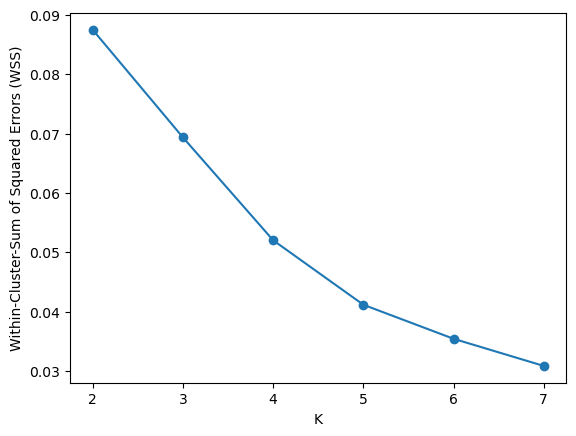

In [54]:
import sklearn.cluster as cluster
K=range(2,8)
wss = []
for k in K:
    kmeans=cluster.KMeans(n_clusters=k)
    kmeans=kmeans.fit(X_day)
    wss_iter = kmeans.inertia_
    wss.append(wss_iter)

plt.xlabel('K')
plt.ylabel('Within-Cluster-Sum of Squared Errors (WSS)')
plt.plot(K,wss, marker='o');


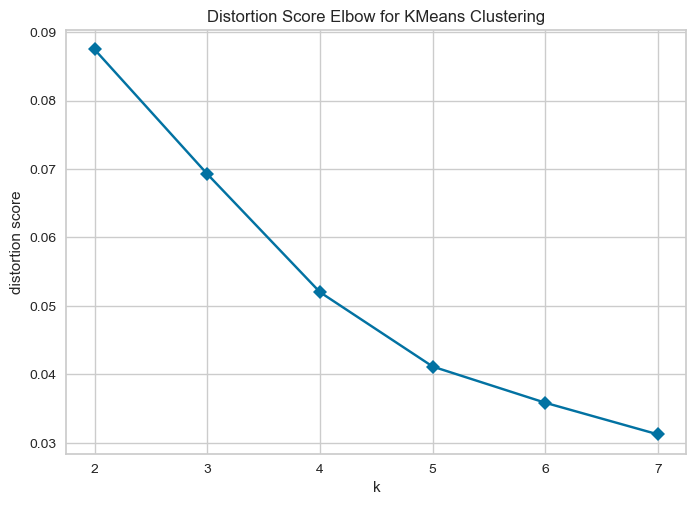

<AxesSubplot:title={'center':'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [94]:
from sklearn import datasets
from sklearn.cluster import KMeans
from yellowbrick.cluster import KElbowVisualizer, SilhouetteVisualizer

# Instantiate the clustering model and visualizer

km = KMeans(random_state=42)
visualizer = KElbowVisualizer(km, k=(2,8), timings=False, locate_elbow=False)
 
visualizer.fit(X_day)        # Fit the data to the visualizer
visualizer.show() 

In [55]:
import sklearn.cluster as cluster
import sklearn.metrics as metrics
for i in range(2,12):
    labels=cluster.KMeans(n_clusters=i,random_state=200).fit(X_day).labels_
    print ("Silhouette score for k(clusters) = "+str(i)+" is "
           +str(metrics.silhouette_score(X_day,labels,metric="euclidean",sample_size=1000,random_state=200)))


Silhouette score for k(clusters) = 2 is 0.3803654735324427
Silhouette score for k(clusters) = 3 is 0.3414030918602456
Silhouette score for k(clusters) = 4 is 0.311648009608077
Silhouette score for k(clusters) = 5 is 0.29650007981360677
Silhouette score for k(clusters) = 6 is 0.28569475127296085
Silhouette score for k(clusters) = 7 is 0.28373576524603045
Silhouette score for k(clusters) = 8 is 0.26301021857472084
Silhouette score for k(clusters) = 9 is 0.2580340963251979
Silhouette score for k(clusters) = 10 is 0.21273290479928356
Silhouette score for k(clusters) = 11 is 0.246611976496261


In [56]:
# k = 3
kmeans = cluster.KMeans(n_clusters=3, random_state=0)
kmeans = kmeans.fit(X_day)
#kmeans = kmeans.fit(pca_df.values)


In [57]:
from sklearn.metrics import silhouette_score

# Calculate Silhoutte Score
score = silhouette_score(X_day, kmeans.labels_, metric='euclidean')
print('Silhouette Score: %.3f' % score)


Silhouette Score: 0.341


Plot cluster

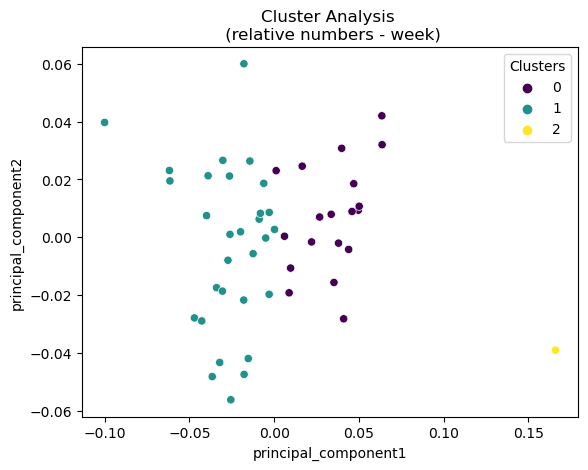

In [58]:

pca_df['Clusters'] = kmeans.labels_
ax = sns.scatterplot(x="principal_component1", y="principal_component2",hue = 'Clusters',  data=pca_df, palette='viridis')
ax.set_title('Cluster Analysis \n (relative numbers - week)')
plt.show()


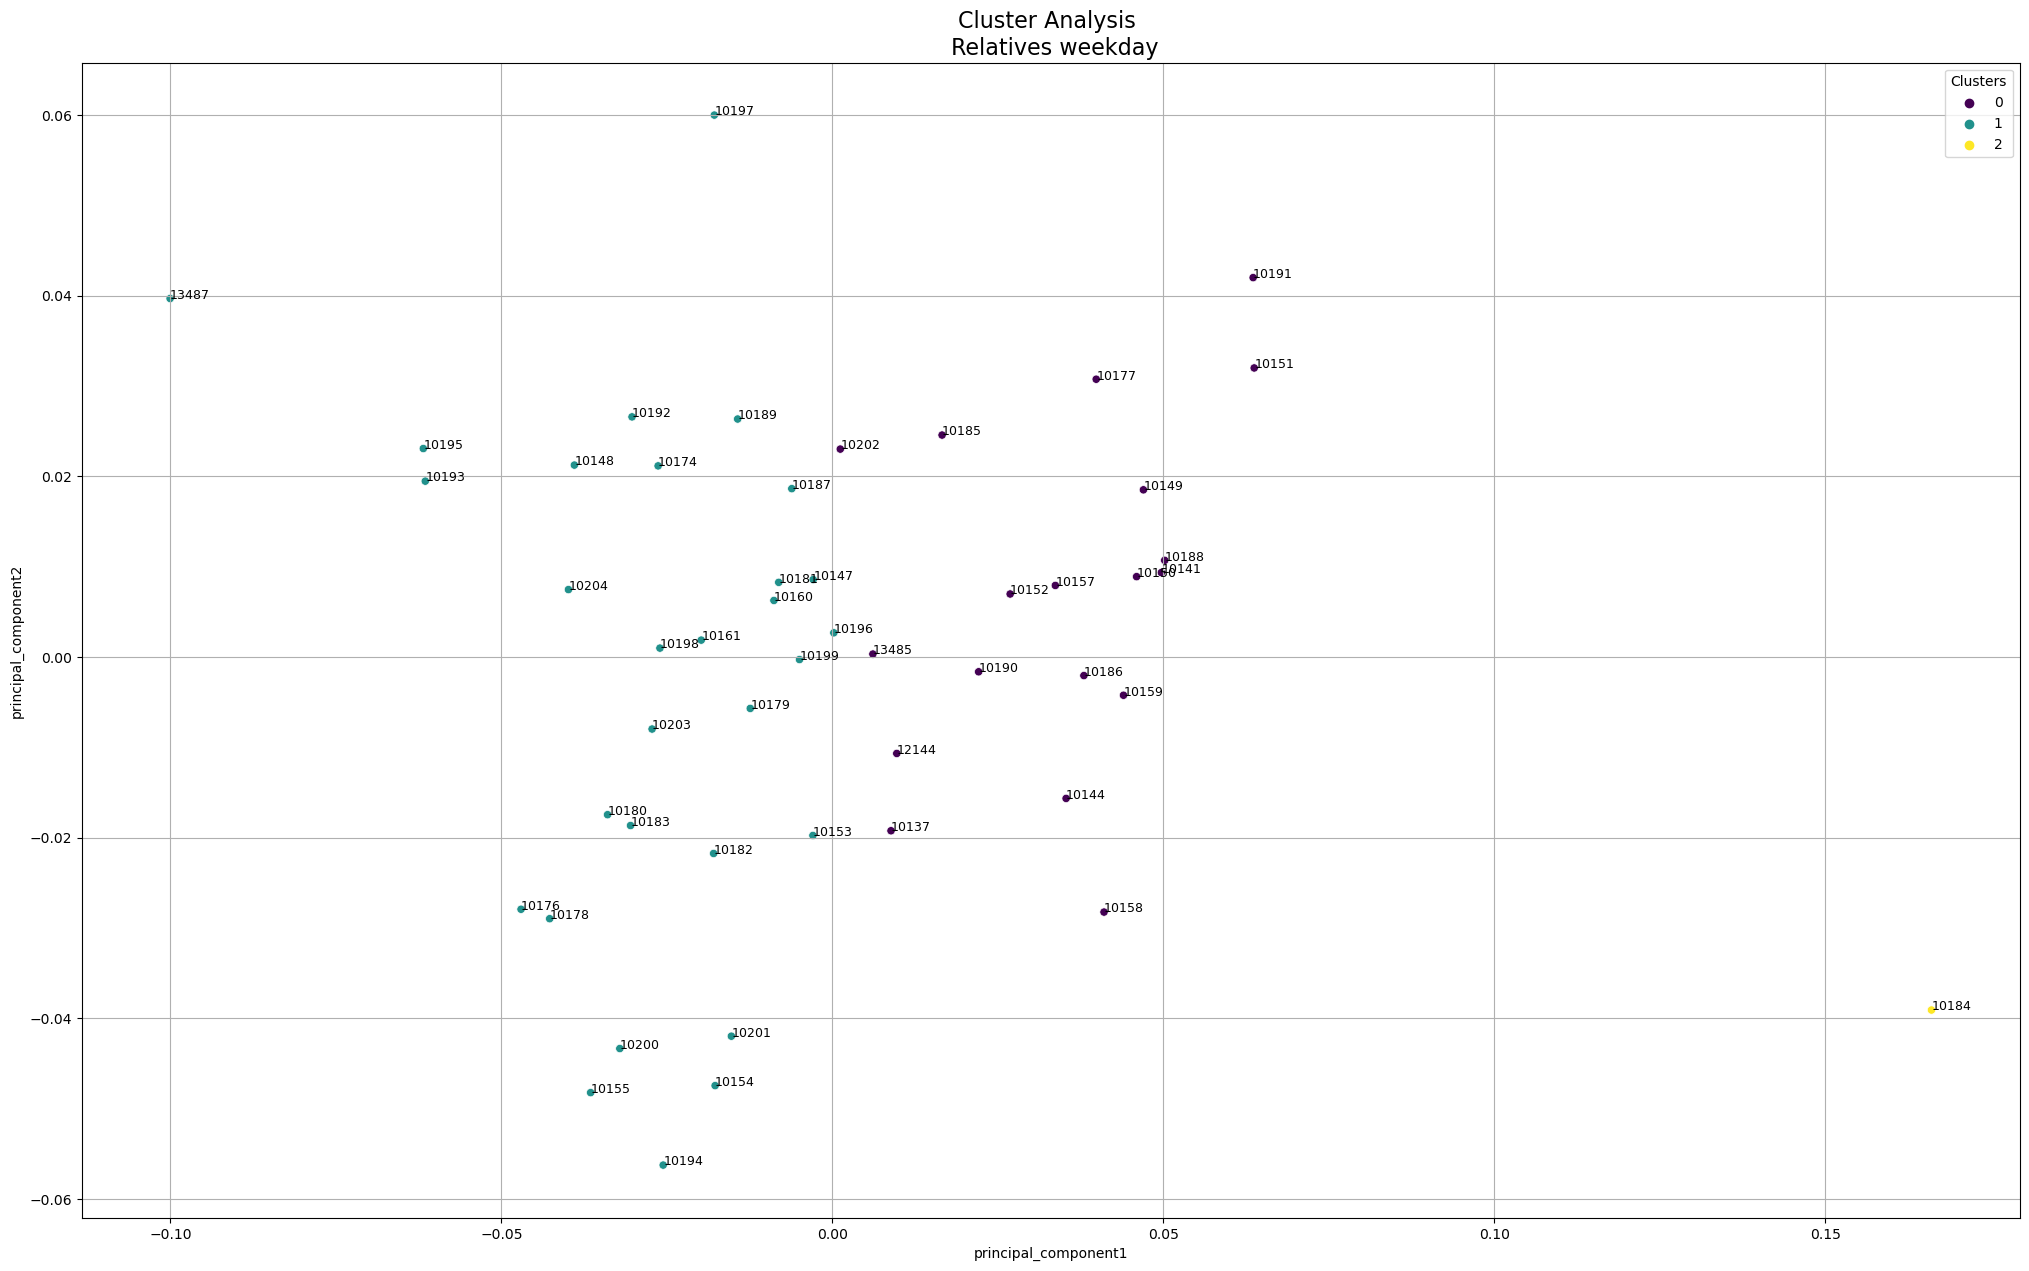

In [67]:
from matplotlib.pyplot import figure

figure(figsize=(25, 15),dpi=100)  
#add zone
pca_df['zone'] = Y_day
# Draw the graph
ax = sns.scatterplot(x="principal_component1", y="principal_component2",hue = 'Clusters',  data=pca_df, palette='viridis')
ax.grid(True)
ax.set_title('Cluster Analysis \n Relatives weekday', fontsize=16)

for i in range(pca_df.shape[0]):
    plt.text(x=pca_df.principal_component1[i],y=pca_df.principal_component2[i],s=pca_df.zone[i], fontsize=9)  #fontdict=dict(color='red', size=10), bbox=dict(facecolor='yellow', alpha=0.5)


# Cluster Analysis, considering weather correlations
- Only fixed zones

In [69]:

corr_df = pd.read_csv('./assets/corr_df.csv')
corr_df = corr_df.drop(['Unnamed: 0'], axis=1)

# Remove temporary sensors 
corr_df = corr_df[corr_df['type_capteur'] != 'temporaire']
corr_df.reset_index(drop=True, inplace=True)
corr_df['type_capteur'].value_counts()


fixe    51
Name: type_capteur, dtype: int64

In [70]:
# Check for NaN under an entire DataFrame:
corr_df.isnull().values.any()


False

In [71]:
X_corr = corr_df.iloc[:,5:].values
#X_corr
X_corr.shape


(51, 2)

In [72]:
kmeans = cluster.KMeans(n_clusters=3, random_state=0)
kmeans = kmeans.fit(X_corr)


In [73]:
from sklearn.metrics import silhouette_score

# Calculate Silhoutte Score
score = silhouette_score(X_corr, kmeans.labels_, metric='euclidean')
print('Silhouette Score: %.3f' % score)


Silhouette Score: 0.468


In [74]:
corr_df['Clusters'] = kmeans.labels_

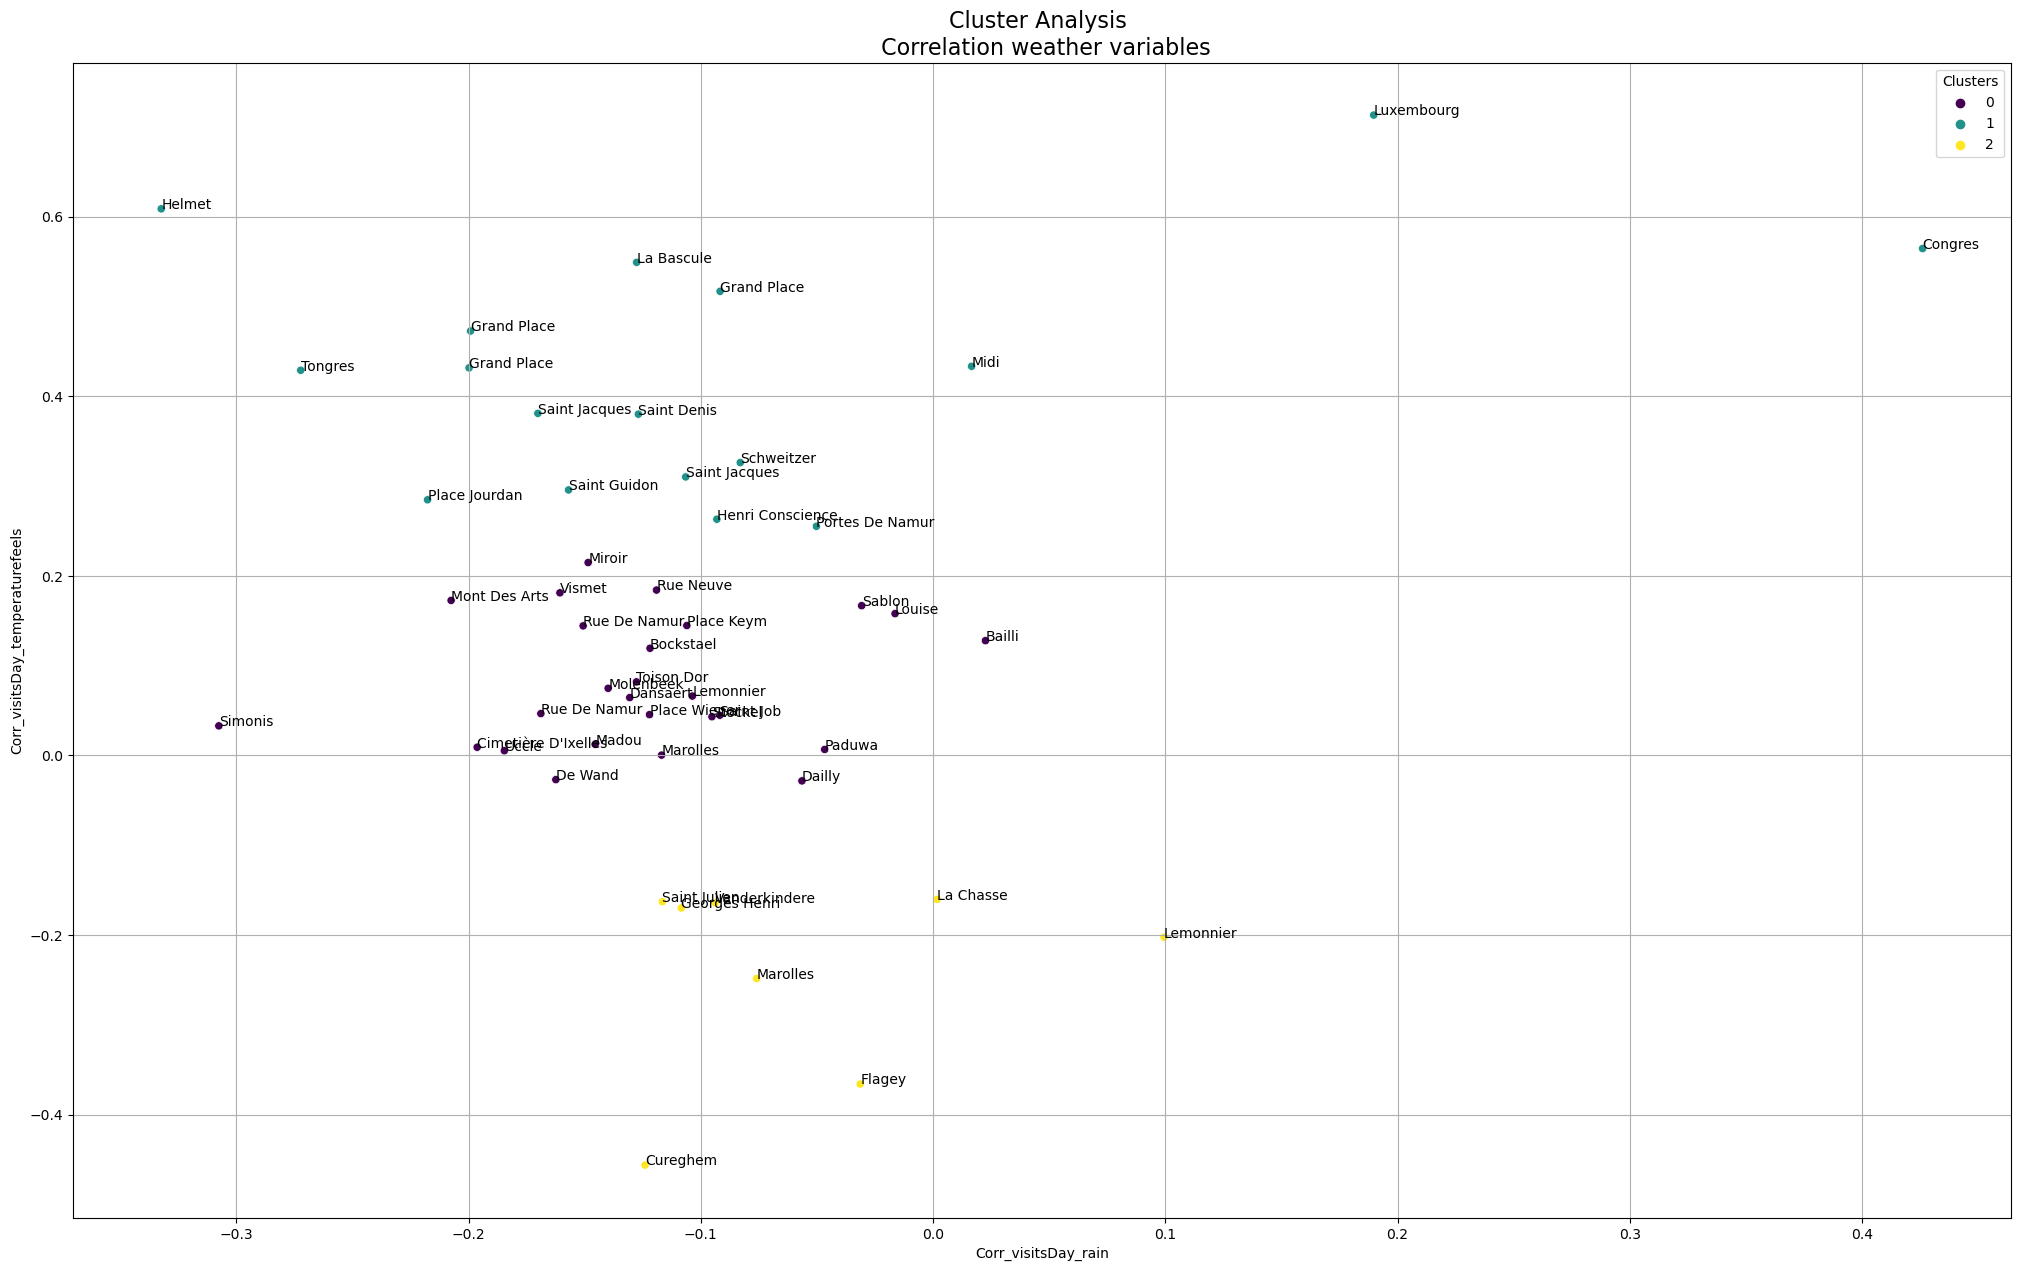

In [75]:
from matplotlib.pyplot import figure

figure(figsize=(25, 15),dpi=100) 

# Draw the graph
ax = sns.scatterplot(x="Corr_visitsDay_rain", y="Corr_visitsDay_temperaturefeels",hue = 'Clusters',  data=corr_df, palette='viridis')
ax.grid(True)
ax.set_title('Cluster Analysis \n Correlation weather variables', fontsize=16)

for i in range(corr_df.shape[0]):
    plt.text(x=corr_df.Corr_visitsDay_rain[i],y=corr_df.Corr_visitsDay_temperaturefeels[i],s=corr_df.Quartier[i], fontsize=10)  


# Cluster analysis: visitors and weather correlations
- Only fixed zones

In [76]:
join_df=pd.merge(corr_df[['zone_id', 'Quartier', 'shop', 'type_capteur', 'number_days',
       'Corr_visitsDay_rain', 'Corr_visitsDay_temperaturefeels',]], day_df[['zone_id', 'Friday', 'Monday', 'Saturday', 'Sunday', 'Thursday',
       'Tuesday', 'Wednesday']], on='zone_id', how='right' )
join_df.shape

(50, 14)

In [77]:
join_df.tail(4)

,zone_id,Quartier,shop,type_capteur,number_days,Corr_visitsDay_rain,Corr_visitsDay_temperaturefeels,Friday,Monday,Saturday,Sunday,Thursday,Tuesday,Wednesday
46,10204,Madou,A la petite vache,fixe,289.0,-0.145487,0.012433,0.141671,0.150644,0.146957,0.087868,0.148031,0.164113,0.160717
47,12144,Toison Dor,Krefel,fixe,165.0,-0.127709,0.081894,0.144067,0.136235,0.180974,0.114615,0.138613,0.143394,0.142102
48,13485,Congres,Inksane,fixe,17.0,0.426056,0.564491,0.165524,0.147367,0.158245,0.118582,0.169058,0.080422,0.160801
49,13487,Luxembourg,Pharmacie,fixe,16.0,0.189732,0.713100,0.163106,0.189957,0.091485,0.060688,0.175267,0.151007,0.168490


In [78]:
join_df.type_capteur.value_counts()

fixe    49
Name: type_capteur, dtype: int64

In [79]:
join_df.to_csv('check.csv')

In [80]:
# Check for NaN under an entire DataFrame:
join_df.isnull().values.any()


True

In [81]:
#  Count the NaN under an entire DataFrame
join_df.isnull().sum().sum()

6

In [82]:
# Drop Rows with NaN Values inplace
join_df.dropna(inplace=True)
join_df.shape

(49, 14)

In [83]:
#Select features
X = join_df.iloc[:,5:].values
X.shape


(49, 9)

In [84]:
# add labels
Y = join_df.iloc[:,:1].values
#Y
Y.shape

(49, 1)

In [ ]:
#Y

In [85]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
principalComponents = pca.fit_transform(X)  
pca_joindf = pd.DataFrame(data = principalComponents
             , columns = ['principal_component1', 'principal_component2'])
pca_joindf.tail(2) 

,principal_component1,principal_component2
47,0.474788,0.488435
48,0.600385,0.248677


In [86]:
# k = 3
kmeans = cluster.KMeans(n_clusters=3, random_state=0)
kmeans = kmeans.fit(X)


In [87]:
from sklearn.metrics import silhouette_score

# Calculate Silhoutte Score
score = silhouette_score(X, kmeans.labels_, metric='euclidean')
print('Silhouette Score: %.3f' % score)


Silhouette Score: 0.435


In [88]:
pca_joindf['Cluster'] = kmeans.labels_
pca_joindf.tail(2)

,principal_component1,principal_component2,Cluster
47,0.474788,0.488435,1
48,0.600385,0.248677,1


In [89]:
#add zone
pca_joindf['zone_id'] = Y
pca_joindf.tail(2)

,principal_component1,principal_component2,Cluster,zone_id
47,0.474788,0.488435,1,13485
48,0.600385,0.248677,1,13487


In [91]:
# Join dataFrames 
zones = pd.read_csv('./assets/zones_modif.csv')
pca_joindf = pd.merge(pca_joindf, zones[['zone_id', 'Quartier', 'shop']], on='zone_id', how='left')
pca_joindf.head(4)

,principal_component1,principal_component2,Cluster,zone_id,Quartier,shop
0,-0.072447,-0.025639,2,10137,Dansaert,K-Way
1,0.382116,-0.027707,1,10141,Grand Place,La Belgique gourmande
2,0.328761,-0.130127,1,10144,Grand Place,La vapotheque
3,0.287392,-0.123604,1,10147,Grand Place,Proximus


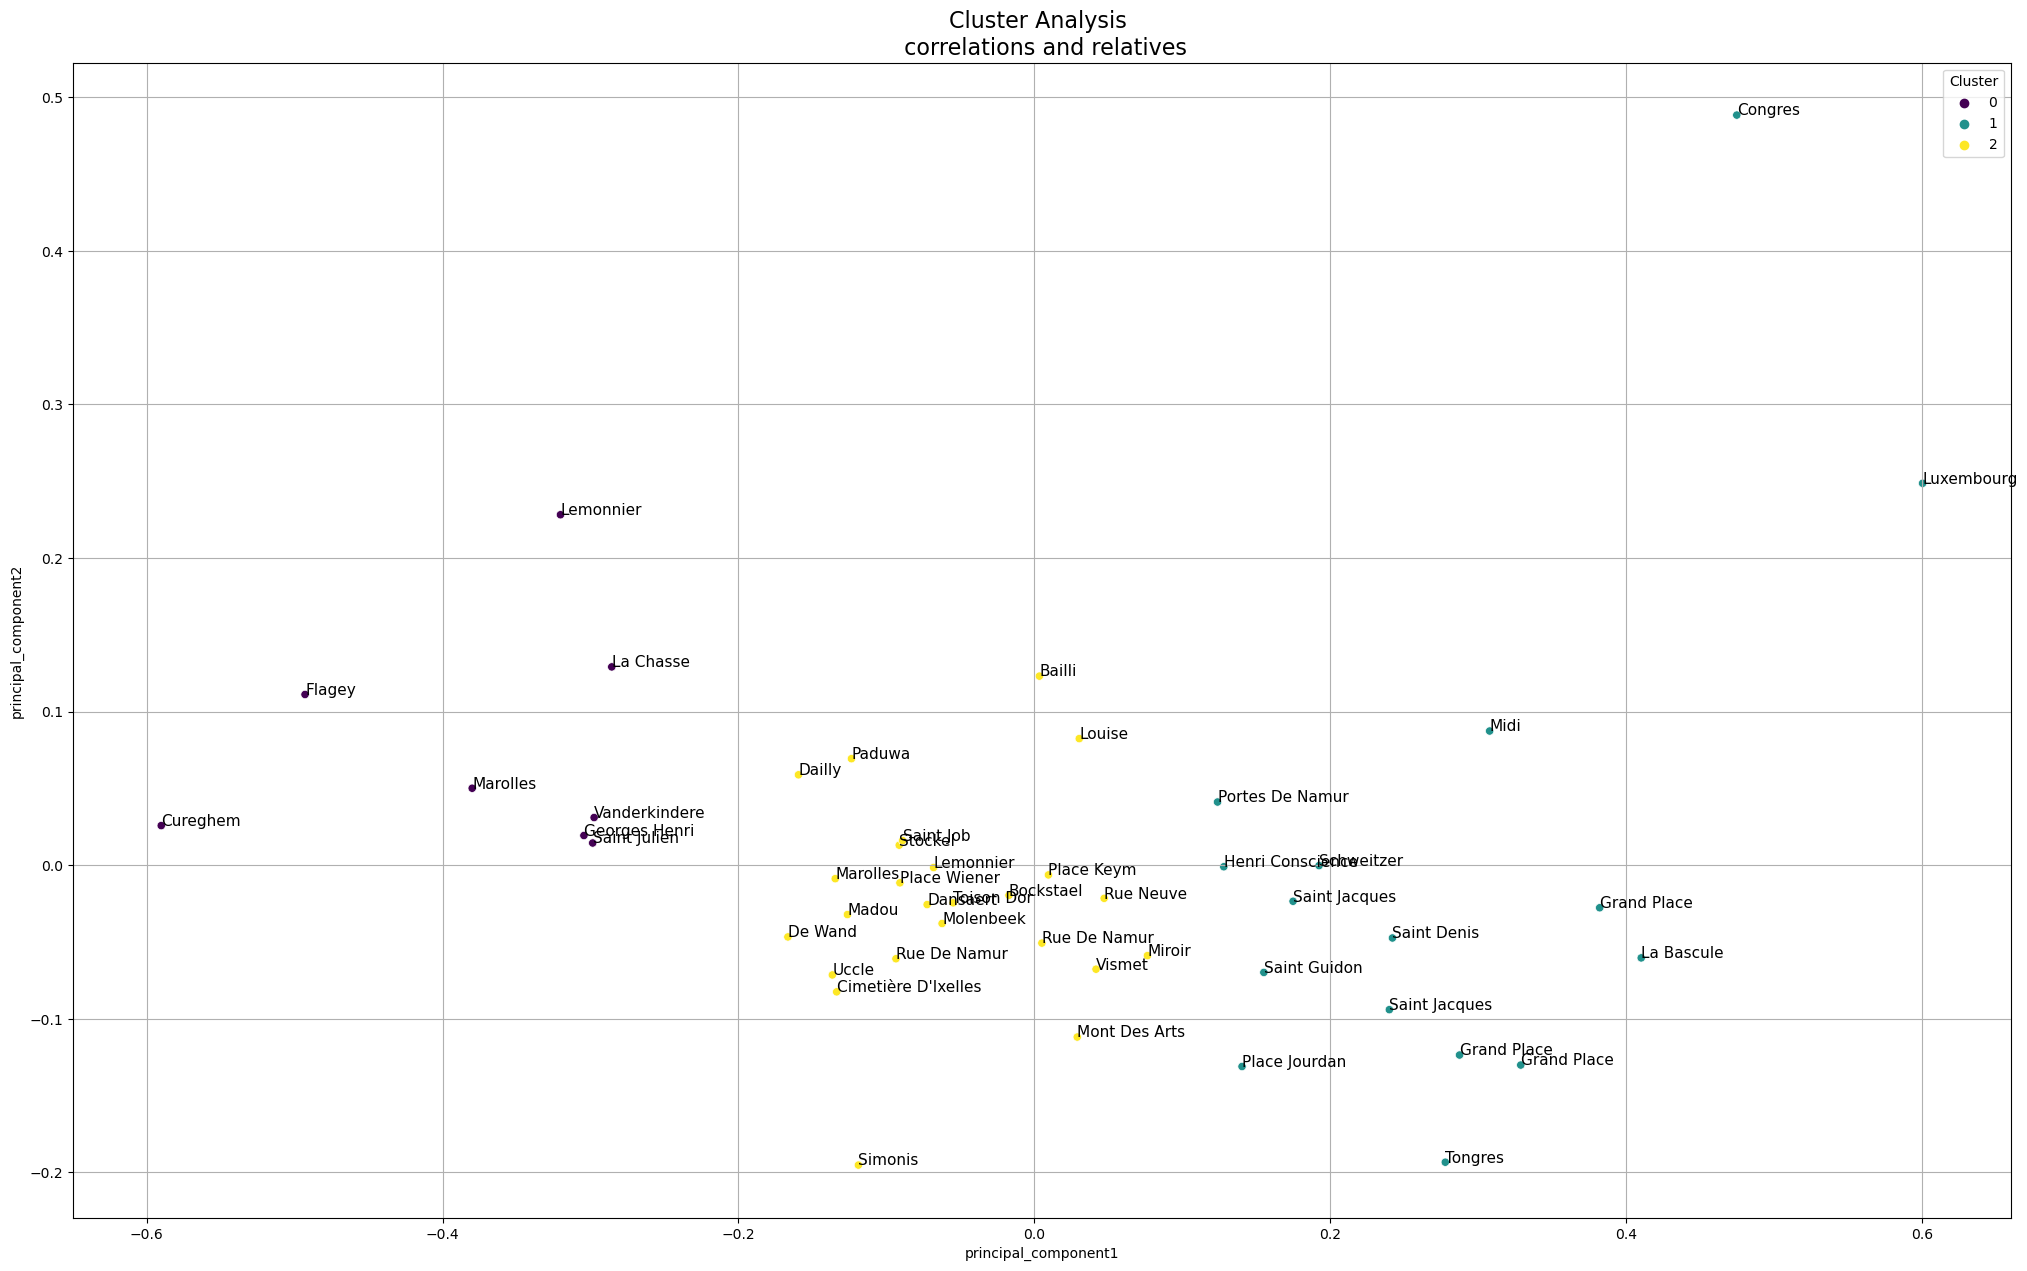

In [93]:
from matplotlib.pyplot import figure

figure(figsize=(25, 15),dpi=100)  

# Draw the graph
ax = sns.scatterplot(x="principal_component1", y="principal_component2",hue = 'Cluster',  data=pca_joindf, palette='viridis')
ax.grid(True)
ax.set_title('Cluster Analysis \n correlations and relatives', fontsize=16)

for i in range(pca_joindf.shape[0]):
    plt.text(x=pca_joindf.principal_component1[i],y=pca_joindf.principal_component2[i],s=pca_joindf.Quartier[i], fontsize=11)
